# Overview of the notebook

We will find the engagement of the users in the forum for the subject TDS

## Take an example of TDS course:

1. Find all the topics from the TDS category's JSON. We can filter them by date to find all the topics that were created in that particular term. STORE ALL TOPIC_IDs in a LIST (say t_list).
2. For each topic_id, there is a user who created it and a bunch of users who replied to that topic. We will STORE EACH USER_ID in a LIST (say u_list).
3. So now we have a list of users who were involved in atleast one topic for the subject TDS.
4. Now we will LOOP THROUGH EACH USER FROM U_LIST, call the API which returns all its user_actions (filtered by date).
5. Loop through all user actions, each user_action is associated with a topic_id. We will analyse only those user_actions whose topic_id is in t_list.

# Global variables and general imports

In [67]:
import os, json, requests, time
from pprint import pprint
from datetime import datetime
import pandas as pd

import yaml
with open("../key.yaml", "r") as file:
    api_keys = yaml.safe_load(file)

api_key = api_keys["API_KEY"]
api_username = "ShubhamG"
defaultHost = "discourse.onlinedegree.iitm.ac.in"

# Headers for authentication
headers = {
    'Api-Key': api_key,
    'Api-Username': api_username
}

after, before = "2024-01-22", "2024-04-28" # Date range for which we want to get the data

# Step 1: Get all the topic_ids of TDS course from the API

In [49]:
slug, id = "tds-kb", 34
page = 0
topic_ids = set() # a set of strings

while True:
    page+=1 # Each page will have 50 topics
    time.sleep(0.8)
    endpoint = f"https://{defaultHost}/search.json?q=%23courses%3A{slug}%20after%3A{after}%20before%3A{before}&page={page}"
    
    response = requests.get(endpoint, headers=headers) # Make the request

    if response.status_code == 200: # Check the response
        data = response.json()
        topic_list = data["topics"]
        topic_ids = set(str(topic["id"]) for topic in topic_list).union(topic_ids)
        if not data['grouped_search_result']['more_full_page_results']: # If there are no more topics, break the loop
            print(f"Number of topics on last page = {page} is {len(topic_list)}")
            break
        
    else:
        print(f'Error: {response.status_code}')
        break
print(f"Total number of topics = {len(topic_ids)}")

Number of topics on last page = 6 is 25
Total number of topics = 275


In [50]:
len(topic_ids), list(topic_ids)[:5]

(275, ['126837', '125327', '125522', '116105', '118356'])

In [51]:
# # Store topic_ids in a text file
# with open('topic_ids.txt', 'w') as f:
#     for topic_id in topic_ids:
#         f.write(f"{topic_id}\n")

# # Retrieve topic_ids from the text file
# with open('topic_ids.txt', 'r') as f:
#     topic_ids = [line.strip() for line in f]

# Step:2 Store each user_id in a list who were involved in above topics

In [52]:
usernames = set() # set of usernames of data type int
for topic_id in topic_ids:
    time.sleep(0.8)
    endpoint = f"https://{defaultHost}/t/{topic_id}.json"
    response = requests.get(url=endpoint, headers=headers)
    if response.status_code==200:
        data = response.json()
        for post in data['post_stream']['posts']: #Each topic has a list of posts, each post has a username
            usernames.add(post['username'])
    else:
        print(f"Error: {response.status_code}\n{response.text}")
        break

In [53]:
len(usernames), list(usernames)[:5]

(287, ['Raunak_Sen', 'Mayur', '23f1001468', 'gNIKHIL', 'SunnyArya01'])

In [54]:
# Store usernames in a text file
with open('usernames.txt', 'w') as f:
    for username in usernames:
        f.write(f"{username}\n")

# Retrieve topic_ids from the text file
with open('usernames.txt', 'r') as f:
    usernames = [line.strip() for line in f]

# STEP 3: GET THE USER_ACTION of each user from usernames_list

In [59]:
# Keep the below code in a loop and increment the offset by 30 each time. The loop should break when the number of elements in the response is less than 30
data_dict ={} # Dictionary to store userActions by username
before_date = datetime.strptime(before, "%Y-%m-%d")
for index, username in enumerate(list(usernames)):
    data_dict[username] = []
    offset = 0
    while True:
        time.sleep(0.8)
        endpoint = f'https://{defaultHost}/user_actions.json?username={username}&offset={offset}&after={after}'
        response = requests.get(endpoint, headers=headers)

        if response.status_code == 200:
            data = response.json()
            user_actions = data["user_actions"]
            num_elements = len(user_actions)

            filtered_user_actions = []
            for action in user_actions:
                topic_id = str(action["topic_id"])
                if (topic_id in topic_ids):
                    created_at = datetime.strptime((action["created_at"]).split("T")[0], "%Y-%m-%d")
                    if created_at <= before_date:
                        filtered_user_actions.append(action)
                        # print(f"topic_id: {topic_id}, created_at: {created_at}")
            data_dict[username].extend(filtered_user_actions)
            offset+=30
            if num_elements<30:
                break
        else:
            print(f'Error: {response.status_code}')
            break
    print(f"Length of user_actions for username= {username} : {len(data_dict[username])}")

Length of user_actions for username= Raunak_Sen : 15
Length of user_actions for username= Mayur : 15
Length of user_actions for username= 23f1001468 : 7
Length of user_actions for username= gNIKHIL : 34
Length of user_actions for username= SunnyArya01 : 9
Length of user_actions for username= 22f1000049 : 5
Length of user_actions for username= 23f1002493 : 2
Length of user_actions for username= Prekshaa : 3
Length of user_actions for username= Palash_25 : 4
Length of user_actions for username= 21f1006477 : 10
Length of user_actions for username= 21f2000243 : 10
Length of user_actions for username= ASR : 4
Length of user_actions for username= Anand : 9
Length of user_actions for username= 22f3002744 : 12
Length of user_actions for username= shijusn : 13
Length of user_actions for username= aaysha007 : 6
Length of user_actions for username= 22f1000718 : 9
Length of user_actions for username= KUSHAL_MISHRA : 10
Length of user_actions for username= Amitpat : 5
Length of user_actions for use

In [61]:
# # dump data_dict as json file
# import json
# with open('data_dict_TDS_T12024.json', 'w') as fp:
#     json.dump(data_dict, fp, indent=4)

# STEP 4: Create a dataframe with the data of all users

In [74]:
action_to_description = {
"1": "likes_given",
"2": "likes_recieved",
"3": "user_bookmarked_a_post",
"4": "created_a_new_topic",
"5": "replied",
"6": "recieved_a_response",
"7": "user_was_mentioned",
"9": "user's_post_was_quoted",
"11": "user_edited_the_post",
"12": "user_sent_a_new_private_message",
"13": "recieved_a_private_message",
"15": "user_marked_a_post_as_solution",
"16": "user_was_assigned_a_topic_or_post",
"17": "linked"
}

def map_user_actions(data_list):
    number_of_actions = {v: 0 for v in action_to_description.values()}
    number_of_actions["Solutions_posted"] = 0
    # Each element of data_list has a key called "action_type". We have to populate the dictionary number_of_actions with the count of each action_type.
    for element in data_list[:]:
        action_int = element["action_type"] # For example, "1"
        action_type = action_to_description[str(action_int)] # If action_int=1, then action_types=likes_given
        number_of_actions[action_type] += 1 # number_of_actions[likes_given] = number_of_actions.get(likes_given, 0) + 1
        if action_int == 5: # This will be used to find the number of solutions posted by the user
            time.sleep(0.8)
            post_id = element["post_id"]
            endpoint = f"https://{defaultHost}/posts/{post_id}.json"

            response = requests.get(endpoint, headers=headers)         
            if response.status_code==200:
                data=response.json()
                if data["accepted_answer"] == True: # the post was accepted as a solution
                    number_of_actions["Solutions_posted"] += 1
            else:
                print(f"Error: {response.status_code}")
                print(response.text)
    return number_of_actions

In [78]:
tds_dataframe = pd.DataFrame(columns=["username"]+[v for k, v in action_to_description.items()]) # dataframe with username and action columns from the action_to_description dictionary
users = list(data_dict.keys())
for index, user in enumerate(users[:]):
    print(index, user)
    # print(data_dict[user])
    D = map_user_actions(data_dict[user])
    D["username"] = user
    tds_dataframe = pd.concat([tds_dataframe, pd.DataFrame(D, index=[0])], ignore_index=True)

tds_dataframe.sample(5)

0 Raunak_Sen
1 Mayur
2 23f1001468
3 gNIKHIL
4 SunnyArya01
5 22f1000049
6 23f1002493
7 Prekshaa
8 Palash_25
9 21f1006477
10 21f2000243
11 ASR
12 Anand
13 22f3002744
14 shijusn
15 aaysha007
16 22f1000718
17 KUSHAL_MISHRA
18 Amitpat
19 21f3002636
20 21f2001224
21 22f1000734
22 ramya_ranjan_rath
23 21f2000485
24 Nihila
25 ulagammai
26 21f3000991
27 21f3002680
28 22f3000959
29 Zer0o
30 21f3001649
31 21f2001481
32 devansh.rungta
33 aachyuthh
34 21f3001237
35 21f2000655
36 Zero
37 22f1000950
38 kabirmalik199
39 22f1000916
40 22f2001152
41 22f2001036
42 23f2003552
43 23ds3000140
44 23ds3000168
45 21f3001965
46 21f2000254
47 Nithin
48 22ds1000070
49 22f2000957
50 Sidharth
51 21f2001138
52 wilber
53 iamprasna
54 21f3002254
55 22f1001971
56 shriaviator
57 23ds3000206
58 23f2001402
59 collegerags7788
60 MOHAMMAD_SAQUIB
61 23f1001228
62 Nishant.G
63 rajan.iitm
64 22f1001142
65 Abhishek2001
66 D.Laha
67 23ds3000172
68 ADI_1792
69 22f2001683
70 SaiShyam
71 Narayanan.POD
72 Navya
73 ramakrishna_iitk
7

,username,likes_given,likes_recieved,user_bookmarked_a_post,created_a_new_topic,replied,recieved_a_response,user_was_mentioned,user's_post_was_quoted,user_edited_the_post,user_sent_a_new_private_message,recieved_a_private_message,user_marked_a_post_as_solution,user_was_assigned_a_topic_or_post,linked,Solutions_posted
23,21f2000485,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0
253,VAIBHAV_MISHRA,1,4,0,1,0,5,0,0,1,0,0,0,0,0,0.0
9,21f1006477,0,1,0,2,2,3,2,0,0,0,0,0,0,0,0.0
72,Navya,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0
163,22f2000861,0,0,0,2,2,3,0,0,0,0,0,0,0,0,0.0


In [79]:
# tds_dataframe.to_csv('tds_engagement.csv', index=False)
# tds_dataframe = pd.read_csv('tds_engagement.csv')

In [80]:
tds_dataframe.drop(columns=["user_bookmarked_a_post","recieved_a_response", "user_was_mentioned","user_edited_the_post","user_sent_a_new_private_message","recieved_a_private_message","user_was_assigned_a_topic_or_post","linked"], inplace=True) # drop the irrelevant columns
tds_dataframe.sample(5)

,username,likes_given,likes_recieved,created_a_new_topic,replied,user's_post_was_quoted,user_marked_a_post_as_solution,Solutions_posted
248,22f2001362,1,7,4,15,0,1,1.0
148,shri_krishna,0,0,0,1,0,0,0.0
125,Vidya,6,1,1,7,0,0,0.0
267,23f2000690,2,34,7,9,0,0,0.0
188,Rajeev_kumar_bhagat,0,0,0,0,0,0,0.0


In [84]:
# Assign the weights to the relevant columns. This can be changed as per the requirement.
weights_dict = { 'likes_given': 0.5, # 0.3
                "likes_recieved": 0.7,
                "created_a_new_topic": 1,
                "replied": 0.7,
                "user's_post_was_quoted": 0.6,
                "user_marked_a_post_as_solution":0.2,
                "Solutions_posted": 1
}
columns_to_be_ignored = ["initial_score",'subject','username','overall_topics_count_of_this_subject', 'normalised_score', 'z_score'] # this was directly taken from previous notebook. Some column names might seem irrelevant. Please ignore them.

tds_dataframe["initial_score"] = sum(tds_dataframe[column]*weights_dict[column] for column in tds_dataframe.columns if column not in columns_to_be_ignored) # Initial score = sum(column_value*weight)

# merged_df["normalised_score"] = merged_df["initial_score"] / merged_df ["overall_topics_count_of_this_subject"] # normalised_score # THIS PART IS OMITTED AS WE ARE CALCULATING THE SCORES ONLY FOR TDS USERS AND NOT COMPARING THEM WITH OTHER SUBJECTS

tds_dataframe["z_score"] = round((tds_dataframe["initial_score"] - tds_dataframe["initial_score"].mean()) / tds_dataframe["initial_score"].std(),2) # z_score

final_scores = tds_dataframe[["username", "initial_score", "z_score"]]

In [88]:
tds_dataframe.to_excel('final_scores.xlsx', index=False)

In [91]:
tds_dataframe[tds_dataframe["z_score"] > 2]

,username,likes_given,likes_recieved,created_a_new_topic,replied,user's_post_was_quoted,user_marked_a_post_as_solution,Solutions_posted,initial_score,z_score
75,Amit1,40,43,6,141,0,12,13.0,170.2,11.51247
76,Learner_HS,1,22,7,23,0,2,2.0,41.4,2.453397
152,23ds1000133,9,18,11,16,0,0,0.0,39.3,2.305695
178,PremKumarGupta,1,34,2,87,1,4,7.0,95.6,6.265523
180,Nithish_Kumar,36,11,0,69,0,5,7.0,82.0,5.308974
198,GKay,6,39,3,47,0,4,4.0,71.0,4.535296
267,23f2000690,2,34,7,9,0,0,0.0,38.1,2.221293


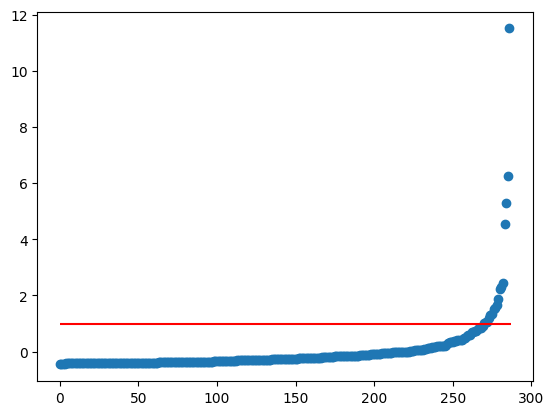

In [97]:
# Plot a scatter plot of the z-scores
import matplotlib.pyplot as plt
z_scores = tds_dataframe["z_score"].sort_values(ascending=True)
plt.scatter(range(0,len(z_scores)),z_scores)
plt.hlines(y=1,xmin=0,xmax=len(z_scores),color='red')
plt.show()